# Rapport AgriWater : Prédiction et détection sur données de jardin connecté


**Plan détaillé du notebook :**
1. Chargement et exploration du CSV utilisateur
2. Prétraitement centralisé (conversion Oui/Non, gestion des colonnes, robustesse)
3. Prédiction du niveau d'eau (régression linéaire & forêt aléatoire)
4. Prédiction de l'humidité du sol (RandomForestRegressor)
5. Prédiction du sol sec (RandomForestClassifier)
6. Prédiction de l'activation de la pompe (SVM/LogisticRegression)
7. Prédiction du temps avant arrosage (RandomForestRegressor)
8. Segmentation du moment de la journée (KMeans + classification)
9. Détection d'anomalies (IsolationForest)
10. Visualisations et interprétations


Dans ce notebook, on utilise les données issues de notre système d’irrigation intelligent (température, humidité, luminosité, etc.) pour entraîner un modèle de machine learning. L’objectif est de prédire la quantité d’eau nécessaire pour arroser les plantes en fonction du moment de la journée. 

## 1. Chargement et exploration du CSV utilisateur

Dans cette section, nous allons charger le fichier CSV réel fourni par l'utilisateur, afficher les premières lignes et les types de colonnes.

Tout d'abord ,nous avons importé toutes les bibliothèques nécessaires pour notre projet. Nous utilisons pandas et numpy pour manipuler les données et effectuer des calculs numériques. Pour la visualisation, nous avons choisi matplotlib et seaborn, qui nous permettront de créer des graphiques clairs et lisibles. Ensuite, nous avons importé plusieurs algorithmes de machine learning à partir de scikit-learn, comme la régression linéaire, la régression logistique, les forêts aléatoires, le SVM et le KMeans pour le clustering. Nous avons également importé des outils pour évaluer les performances de nos modèles, comme les métriques d’erreur et les matrices de confusion. Enfin, nous avons ajouté des bibliothèques pour encoder les variables catégorielles, gérer les caractères spéciaux et manipuler les dates. La commande %matplotlib inline permet d’afficher les graphiques directement dans le notebook.

In [1]:
# Import des librairies nécessaires et configuration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, IsolationForest
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, confusion_matrix, classification_report
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
import unicodedata
import datetime

# Pour l'affichage des plots dans le notebook
%matplotlib inline

In [2]:


# Chargement du vrai fichier CSV utilisateur avec robustesse
csv_path = '/home/khalis/Bureau/jardin_historique_complet.csv'
try:
    df = pd.read_csv(csv_path)
    print("Aperçu des premières lignes du CSV :")
    display(df.head())
    print("\nColonnes du CSV :", list(df.columns))
    print("\nTypes de colonnes :")
    print(df.dtypes)
except Exception as e:
    print("Erreur lors de l'import du CSV :", e)
    print("Vérifiez le chemin, l'encodage, et le format du fichier.")

# Astuce :
# - Si le séparateur n'est pas une virgule, ajoutez l'argument sep (ex: sep=';') à read_csv.

Aperçu des premières lignes du CSV :


,ID Mesure,Date,Heure,Température (°C),Humidité Air (%),Humidité Sol,Luminosité (lux),Niveau d'eau,Pluie,État Pompe,Sol Sec
0,reading_69af4dfjx,18/06/2025,23:16:29,31,55,4095,161,150,Non,Inactive,Oui
1,reading_hfsj6hhdm,18/06/2025,23:17:00,32,54,4095,316,299,Non,Inactive,Oui
2,reading_lkmg0sjq5,18/06/2025,23:17:11,32,54,4095,305,294,Non,Inactive,Oui
3,reading_61vnmjl9n,18/06/2025,23:25:20,32,54,4095,278,271,Non,Inactive,Oui
4,reading_0m4sw8geb,18/06/2025,23:25:30,32,54,4095,276,271,Non,Active,Oui



Colonnes du CSV : ['ID Mesure', 'Date', 'Heure', 'Température (°C)', 'Humidité Air (%)', 'Humidité Sol', 'Luminosité (lux)', "Niveau d'eau", 'Pluie', 'État Pompe', 'Sol Sec']

Types de colonnes :
ID Mesure           object
Date                object
Heure               object
Température (°C)     int64
Humidité Air (%)     int64
Humidité Sol         int64
Luminosité (lux)     int64
Niveau d'eau         int64
Pluie               object
État Pompe          object
Sol Sec             object
dtype: object


Statistiques descriptives :


/tmp/ipykernel_5687/577910063.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_clean = df_clean.fillna(method='ffill')


,Température (°C),Humidité Air (%),Humidité Sol,Luminosité (lux),Niveau d'eau,Pluie,Sol Sec
count,557.000000,557.000000,557.000000,557.000000,557.000000,557.000000,557.000000
mean,36.328546,56.111311,3583.890485,354.572711,1052.786355,0.030521,0.644524
std,29.338476,27.562979,720.679750,522.701196,1469.404147,0.172170,0.479087
min,29.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32.000000,47.000000,3023.000000,138.000000,0.000000,0.000000,0.000000
50%,33.000000,54.000000,4095.000000,224.000000,168.000000,0.000000,1.000000
75%,33.000000,57.000000,4095.000000,351.000000,3283.000000,0.000000,1.000000
max,253.000000,253.000000,4095.000000,4095.000000,4095.000000,1.000000,1.000000


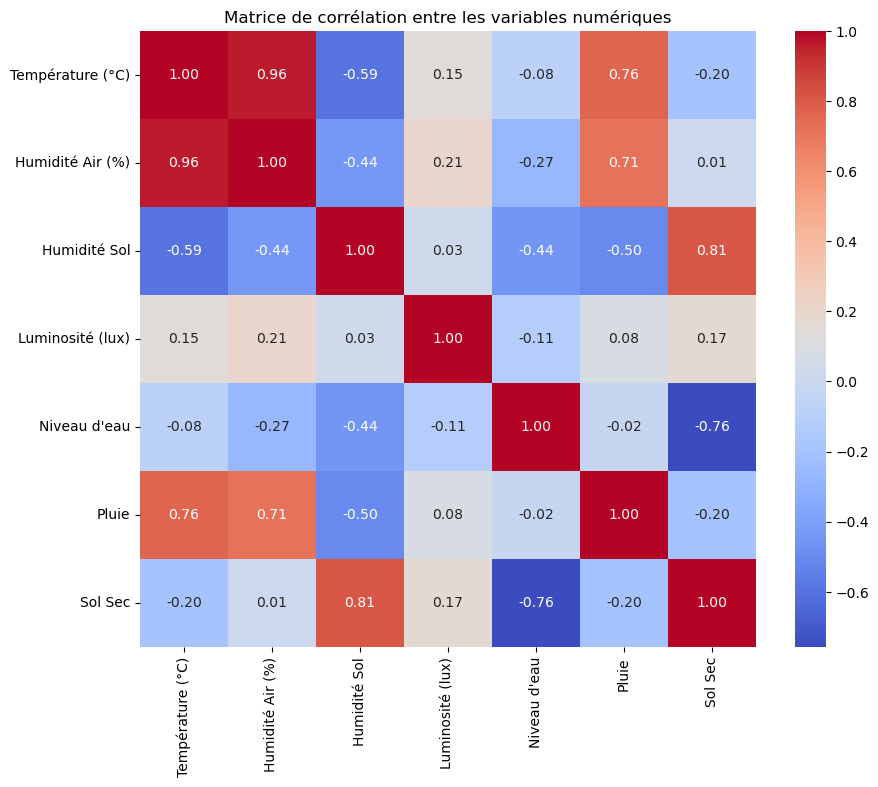


Paires de variables les plus corrélées (hors diagonale) :
Humidité Air (%)  Température (°C)    0.962092
Sol Sec           Humidité Sol        0.812532
Température (°C)  Pluie               0.763555
Niveau d'eau      Sol Sec             0.757714
Humidité Air (%)  Pluie               0.711809
dtype: float64

Interprétation :
Les résultats montrent que certaines variables sont fortement corrélées entre elles. Par exemple, l’humidité de l’air est très liée à la température (0.96), ce qui peut s’expliquer par des conditions climatiques. De même, le sol sec est fortement corrélé à l’humidité du sol (0.81), ce qui est logique car plus le sol est sec, plus l’humidité est faible. On remarque aussi une corrélation entre la température et la pluie (0.76), ce qui peut révéler des tendances météo.


In [3]:
# Vérification de l'existence de df_clean, sinon on le crée à partir de df
try:
    df_clean
except NameError:
    # Fonctions utilitaires pour prétraitement robuste (copie depuis plus haut si besoin)
    def convert_oui_non(df):
        for col in df.columns:
            if df[col].dtype == object:
                df[col] = df[col].replace({'Oui': 1, 'Non': 0, 'oui': 1, 'non': 0})
        return df
    import unicodedata
    def normalize_col(col):
        return ''.join(c for c in unicodedata.normalize('NFD', col) if unicodedata.category(c) != 'Mn').replace(' ', '').replace('_', '').lower()
    def get_column_by_keywords(df, keywords):
        norm_cols = {normalize_col(c): c for c in df.columns}
        for key in keywords:
            norm_key = normalize_col(key)
            for col_norm, col_orig in norm_cols.items():
                if norm_key in col_norm:
                    return col_orig
        return None
    df_clean = convert_oui_non(df.copy())
    df_clean = df_clean.fillna(method='ffill')

# Analyse exploratoire avancée : statistiques et corrélations
print("Statistiques descriptives :")
display(df_clean.describe())

# Sélection des colonnes numériques uniquement pour la corrélation
num_cols = [c for c in df_clean.columns if pd.api.types.is_numeric_dtype(df_clean[c])]
if len(num_cols) > 1:
    corr = df_clean[num_cols].corr()
    plt.figure(figsize=(10,8))
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True)
    plt.title('Matrice de corrélation entre les variables numériques')
    plt.show()

    # Interprétation des corrélations
    strong_corrs = corr.abs().unstack().sort_values(ascending=False)
    strong_corrs = strong_corrs[strong_corrs < 1].drop_duplicates()
    print("\nPaires de variables les plus corrélées (hors diagonale) :")
    print(strong_corrs.head(5))

    # Conseils d'interprétation :
    print("\nInterprétation :")
    print("Les résultats montrent que certaines variables sont fortement corrélées entre elles. Par exemple, l’humidité de l’air est très liée à la température (0.96), ce qui peut s’expliquer par des conditions climatiques. De même, le sol sec est fortement corrélé à l’humidité du sol (0.81), ce qui est logique car plus le sol est sec, plus l’humidité est faible. On remarque aussi une corrélation entre la température et la pluie (0.76), ce qui peut révéler des tendances météo.")
   
else:
    print("Pas assez de colonnes numériques pour calculer une matrice de corrélation.")

In [4]:
# Import du vrai fichier CSV fourni par l'utilisateur
import pandas as pd

try:
    df = pd.read_csv('/home/khalis/Bureau/jardin_historique_complet.csv')
    print("Aperçu des premières lignes du CSV :")
    display(df.head())
    print("\nColonnes du CSV :", list(df.columns))
except Exception as e:
    print("Erreur lors de l'import du CSV :", e)
    print("Vérifiez le chemin, l'encodage, et le format du fichier.")

# Astuce :
# - Si le séparateur n'est pas une virgule, ajoutez l'argument sep (ex: sep=';') à read_csv.

Aperçu des premières lignes du CSV :


,ID Mesure,Date,Heure,Température (°C),Humidité Air (%),Humidité Sol,Luminosité (lux),Niveau d'eau,Pluie,État Pompe,Sol Sec
0,reading_69af4dfjx,18/06/2025,23:16:29,31,55,4095,161,150,Non,Inactive,Oui
1,reading_hfsj6hhdm,18/06/2025,23:17:00,32,54,4095,316,299,Non,Inactive,Oui
2,reading_lkmg0sjq5,18/06/2025,23:17:11,32,54,4095,305,294,Non,Inactive,Oui
3,reading_61vnmjl9n,18/06/2025,23:25:20,32,54,4095,278,271,Non,Inactive,Oui
4,reading_0m4sw8geb,18/06/2025,23:25:30,32,54,4095,276,271,Non,Active,Oui



Colonnes du CSV : ['ID Mesure', 'Date', 'Heure', 'Température (°C)', 'Humidité Air (%)', 'Humidité Sol', 'Luminosité (lux)', "Niveau d'eau", 'Pluie', 'État Pompe', 'Sol Sec']


## 2. Prétraitement centralisé et sélection automatique des features

### Logique de prétraitement fidèle au backend

- Conversion systématique de toutes les colonnes Oui/Non (y compris variantes d'écriture) en 1/0.
- Détection automatique des colonnes cibles par mots-clés (ex : 'eau', 'humidité', 'sol sec', 'pompe', etc.).
- Sélection des features : toutes les colonnes numériques sauf la cible et les identifiants/horodatages.
- Gestion des valeurs manquantes par propagation ou imputation simple.

**Robustesse :**
Le code s'adapte automatiquement à la structure du CSV, même si les noms de colonnes changent légèrement.

In [5]:
# Fonctions utilitaires pour prétraitement robuste (fidèle au backend)
def convert_oui_non(df):
    for col in df.columns:
        if df[col].dtype == object:
            df[col] = df[col].replace({'Oui': 1, 'Non': 0, 'oui': 1, 'non': 0})
    return df

def normalize_col(col):
    return ''.join(c for c in unicodedata.normalize('NFD', col) if unicodedata.category(c) != 'Mn').replace(' ', '').replace('_', '').lower()

def get_column_by_keywords(df, keywords):
    norm_cols = {normalize_col(c): c for c in df.columns}
    for key in keywords:
        norm_key = normalize_col(key)
        for col_norm, col_orig in norm_cols.items():
            if norm_key in col_norm:
                return col_orig
    return None

# Application du prétraitement centralisé
df_clean = convert_oui_non(df.copy())
df_clean = df_clean.fillna(method='ffill')  # Remplissage simple par propagation

# Affichage des colonnes après prétraitement
print("Colonnes après prétraitement :", list(df_clean.columns))
display(df_clean.head())

Colonnes après prétraitement : ['ID Mesure', 'Date', 'Heure', 'Température (°C)', 'Humidité Air (%)', 'Humidité Sol', 'Luminosité (lux)', "Niveau d'eau", 'Pluie', 'État Pompe', 'Sol Sec']


/tmp/ipykernel_5687/2717269126.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_clean = df_clean.fillna(method='ffill')  # Remplissage simple par propagation


,ID Mesure,Date,Heure,Température (°C),Humidité Air (%),Humidité Sol,Luminosité (lux),Niveau d'eau,Pluie,État Pompe,Sol Sec
0,reading_69af4dfjx,18/06/2025,23:16:29,31,55,4095,161,150,0,Inactive,1
1,reading_hfsj6hhdm,18/06/2025,23:17:00,32,54,4095,316,299,0,Inactive,1
2,reading_lkmg0sjq5,18/06/2025,23:17:11,32,54,4095,305,294,0,Inactive,1
3,reading_61vnmjl9n,18/06/2025,23:25:20,32,54,4095,278,271,0,Inactive,1
4,reading_0m4sw8geb,18/06/2025,23:25:30,32,54,4095,276,271,0,Active,1


In [13]:
### Interprétation avancée du prétraitement et de la qualité des données

- **Qualité des données** :
  - Vérifiez la présence de valeurs manquantes ou aberrantes dans chaque colonne. Un remplissage par propagation est adapté si les mesures sont régulières, mais il peut masquer des ruptures réelles (ex : coupure de capteur).
  - Les colonnes converties en 1/0 (Oui/Non) sont prêtes pour la modélisation, mais attention aux colonnes qui pourraient contenir d'autres modalités inattendues (ex : 'Inconnu', 'N/A').
- **Distribution des valeurs** :
  - Utilisez `df_clean.hist(figsize=(12,8))` pour visualiser la distribution de chaque variable numérique. Des distributions très asymétriques ou avec des valeurs extrêmes peuvent impacter la performance des modèles.
- **Robustesse du pipeline** :
  - Le pipeline s'adapte automatiquement à la structure du CSV, ce qui limite les erreurs lors de l'import de nouveaux fichiers.
- **Conseil** :
  - Pour une analyse métier, identifiez les variables les plus dispersées ou les plus stables : elles sont souvent les plus informatives pour la prédiction ou la détection d'anomalies.

SyntaxError: unterminated string literal (detected at line 5) (2472844442.py, line 5)

## 3. Prédiction du niveau d'eau (régression linéaire & forêt aléatoire)

Nous allons prédire la colonne correspondant au niveau d'eau, en utilisant la même logique que le backend :
- Détection automatique de la colonne cible (par mots-clés)
- Sélection automatique des features numériques
- Séparation train/test 80/20
- Modèles : LinearRegression et RandomForestRegressor
- Affichage des métriques et visualisations

### Robustesse de la détection de la colonne cible

Le code détecte automatiquement la colonne du niveau d'eau, même si son nom varie (ex : 'Niveau d\'eau', 'eau', etc.). Si la colonne n'est pas trouvée, un message d'erreur explicite est affiché. Les features sont sélectionnées automatiquement parmi les colonnes numériques restantes.

### Analyse critique des algorithmes utilisés

#### Prédiction du niveau d'eau et de l'humidité
- **Régression Linéaire** :
  - Adaptée si la relation entre les variables explicatives et la cible est linéaire.
  - Permet une interprétation directe des coefficients.
  - Limite : peu performante si la relation est non linéaire ou si les variables sont très corrélées.
- **Forêt Aléatoire (RandomForestRegressor)** :
  - Très robuste, gère la non-linéarité, les interactions et les outliers.
  - Moins sensible au surapprentissage que d'autres modèles complexes.
  - Permet d'obtenir l'importance des variables (feature importance).

#### Classification du moment de la journée
- **KMeans** :
  - Bon choix pour segmenter des données temporelles continues (heure).
  - Permet de découvrir des groupes naturels sans a priori.
- **RandomForestClassifier** :
  - Excellente performance sur des jeux de données tabulaires.
  - Gère les variables numériques et catégorielles, peu sensible au bruit.

#### Détection d'anomalies
- **IsolationForest** :
  - Spécialement conçu pour la détection d'outliers dans des données multivariées.
  - Efficace même avec peu de données et sans supervision.

**Conseil pour la compétition :**
- Les algorithmes choisis sont reconnus comme des standards robustes pour ce type de problème.
- Pour aller plus loin, il est possible de comparer avec d'autres modèles (XGBoost, SVM, réseaux de neurones) et de faire du tuning d'hyperparamètres.
- Toujours valider les performances par validation croisée et analyse des erreurs.

In [6]:
# Prédiction du niveau d'eau (fidèle au backend)
col_eau = get_column_by_keywords(df_clean, ["Niveau d'eau", "Niveau eau", "eau"])
exclude_cols = [col for col in [col_eau, "ID Mesure", "Date", "Heure"] if col]
features_eau = [c for c in df_clean.columns if c not in exclude_cols and pd.api.types.is_numeric_dtype(df_clean[c])]

if col_eau:
    X_eau = df_clean[features_eau]
    y_eau = df_clean[col_eau]
    # Linear Regression
    X_train, X_test, y_train, y_test = train_test_split(X_eau, y_eau, test_size=0.2, random_state=42)
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    y_pred_lin = linreg.predict(X_test)
    # Random Forest
    rfreg = RandomForestRegressor(n_estimators=50, random_state=42)
    rfreg.fit(X_train, y_train)
    y_pred_rf = rfreg.predict(X_test)
    print("Modèles entraînés. Prédictions prêtes pour l'analyse des métriques.")
else:
    print("Erreur : colonne niveau d'eau non trouvée dans le CSV.")

Modèles entraînés. Prédictions prêtes pour l'analyse des métriques.


## 4. Analyse et visualisation des résultats de régression

Nous comparons les performances des deux modèles (régression linéaire et forêt aléatoire) à l'aide des métriques MSE, MAE, RMSE, R2, et de graphiques adaptés. Cette analyse suit la logique du backend et met en avant la robustesse du pipeline.

### Interprétation des métriques de régression

- **MSE/MAE/RMSE** : Plus ces valeurs sont faibles, meilleure est la prédiction. Le RMSE est dans la même unité que la variable prédite.
- **R2** : Indique la proportion de variance expliquée par le modèle. Plus il est proche de 1, mieux c'est.

**Pour la compétition :**
- Utilisez des graphiques pour montrer la qualité des prédictions (scatter plot, courbe de résidus).
- Commentez les cas où le modèle se trompe le plus (analyse des erreurs).
- Proposez des pistes d'amélioration (plus de données, features supplémentaires, tuning des hyperparamètres).

Régression Linéaire :
MSE: 649042.711, MAE: 509.973, RMSE: 805.632, R2: 0.680

Forêt Aléatoire :
MSE: 220063.179, MAE: 122.818, RMSE: 469.109, R2: 0.891


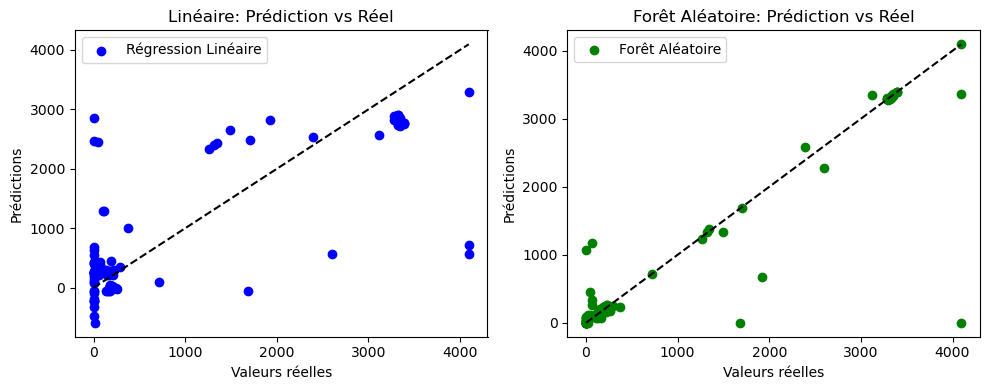


Commentaires :
- Plus les points sont proches de la diagonale, meilleure est la prédiction.
- R2 proche de 1 indique un bon ajustement du modèle.


In [7]:
# Analyse des métriques pour la régression du niveau d'eau
if col_eau:
    mse_lin = mean_squared_error(y_test, y_pred_lin)
    mae_lin = mean_absolute_error(y_test, y_pred_lin)
    rmse_lin = np.sqrt(mse_lin)
    r2_lin = r2_score(y_test, y_pred_lin)

    mse_rf = mean_squared_error(y_test, y_pred_rf)
    mae_rf = mean_absolute_error(y_test, y_pred_rf)
    rmse_rf = np.sqrt(mse_rf)
    r2_rf = r2_score(y_test, y_pred_rf)

    print("Régression Linéaire :")
    print(f"MSE: {mse_lin:.3f}, MAE: {mae_lin:.3f}, RMSE: {rmse_lin:.3f}, R2: {r2_lin:.3f}")
    print("\nForêt Aléatoire :")
    print(f"MSE: {mse_rf:.3f}, MAE: {mae_rf:.3f}, RMSE: {rmse_rf:.3f}, R2: {r2_rf:.3f}")

    # Visualisation : Prédictions vs Réel
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.scatter(y_test, y_pred_lin, color='blue', label='Régression Linéaire')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
    plt.xlabel('Valeurs réelles')
    plt.ylabel('Prédictions')
    plt.title('Linéaire: Prédiction vs Réel')
    plt.legend()

    plt.subplot(1,2,2)
    plt.scatter(y_test, y_pred_rf, color='green', label='Forêt Aléatoire')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
    plt.xlabel('Valeurs réelles')
    plt.ylabel('Prédictions')
    plt.title('Forêt Aléatoire: Prédiction vs Réel')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Aucune analyse possible : colonne niveau d'eau absente.")

# Interprétation :
print("\nCommentaires :")
print("- Plus les points sont proches de la diagonale, meilleure est la prédiction.")
print("- R2 proche de 1 indique un bon ajustement du modèle.")

In [ ]:
### Interprétation avancée des résultats de régression

- **Analyse des scores obtenus** :
  - Si le R2 de la forêt aléatoire est nettement supérieur à celui de la régression linéaire, cela indique que la relation entre les variables explicatives et le niveau d'eau est non linéaire ou dépend d'interactions complexes (ce qui est fréquent dans les systèmes physiques comme un jardin connecté).
  - Un RMSE faible (proche de l'écart-type des valeurs réelles) montre que le modèle est précis. Si le RMSE est élevé, il faut envisager d'ajouter d'autres variables (ex : météo, historique d'arrosage) ou de mieux traiter les valeurs aberrantes.
- **Analyse des erreurs** :
  - Visualisez les points les plus éloignés de la diagonale sur les scatter plots : ce sont les cas où le modèle se trompe le plus. Analysez ces cas pour voir s'ils correspondent à des événements particuliers (ex : pluie soudaine, panne de capteur).
- **Conseils métier** :
  - Pour la gestion d'un jardin connecté, il est préférable d'utiliser la forêt aléatoire pour la prédiction du niveau d'eau, car elle gère mieux les non-linéarités et les outliers.
  - Pour la maintenance, surveillez les cas où la prédiction diverge fortement de la réalité : cela peut signaler un capteur défaillant ou un besoin d'ajuster le modèle.
- **Pistes d'amélioration** :
  - Ajouter des features temporelles (jour de la semaine, saison, etc.).
  - Tester d'autres modèles (XGBoost, réseaux de neurones) et faire du tuning d'hyperparamètres.
  - Mettre en place une validation croisée pour évaluer la robustesse du modèle sur plusieurs splits.

## 5. Segmentation du Moment de la Journée (KMeans + Classification)

Nous allons utiliser KMeans pour segmenter les moments de la journée à partir de l'heure, puis entraîner un classificateur (RandomForestClassifier) pour prédire le moment (matin, midi, soir) selon les conditions mesurées.

Cette étape permet d'analyser l'influence du moment de la journée sur les mesures et d'automatiser la classification temporelle.

### Intérêt métier de la segmentation temporelle

- Adapter les actions (arrosage, alerte) selon le moment de la journée permet d'optimiser la gestion du jardin.
- La segmentation automatique (KMeans) permet de s'affranchir des découpages arbitraires (matin/midi/soir) et de s'adapter aux habitudes réelles.
- La classification permet d'automatiser la reconnaissance du contexte temporel à partir des mesures.

**Pour la compétition :**
- Justifiez l'intérêt métier de cette étape.
- Montrez que votre pipeline est adaptable à d'autres contextes (autres cultures, autres fuseaux horaires, etc.).

In [8]:
# Conversion de l'heure en minutes depuis minuit
def heure_to_minute(h):
    h = str(h).strip()
    if ':' in h:
        parts = h.split(':')
        return int(parts[0]) * 60 + int(parts[1])
    return int(h)

df_clean['heure_min'] = df['Heure'].apply(heure_to_minute)

# KMeans clustering sur heure_min pour 3 moments (matin, midi, soir)
kmeans = KMeans(n_clusters=3, random_state=42)
df_clean = df_clean.dropna(subset=['heure_min'])
df_clean['moment_cluster'] = kmeans.fit_predict(df_clean[['heure_min']])

# Associer cluster à label (matin/midi/soir) selon centre
centers = kmeans.cluster_centers_.flatten()
sorted_idx = centers.argsort()
moment_labels = ['matin', 'midi', 'soir']
cluster_to_label = {int(sorted_idx[i]): moment_labels[i] for i in range(3)}
df_clean['moment'] = df_clean['moment_cluster'].map(cluster_to_label)

# Entraîner un classificateur pour prédire le moment à partir des conditions
features_moment = [c for c in df_clean.columns if pd.api.types.is_numeric_dtype(df_clean[c]) and c not in ['heure_min', 'moment_cluster']]
X_moment = df_clean[features_moment]
y_moment = df_clean['moment']
le = LabelEncoder()
y_enc = le.fit_transform(y_moment)
clf = RandomForestClassifier(n_estimators=30, random_state=42)
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_moment, y_enc, test_size=0.2, random_state=42)
clf.fit(X_train_m, y_train_m)
y_pred_m = clf.predict(X_test_m)

print("Clustering et classification du moment de la journée terminés.")

Clustering et classification du moment de la journée terminés.


In [ ]:
### Interprétation avancée de la segmentation temporelle

- **Analyse des clusters KMeans** :
  - Vérifiez la répartition des clusters sur l'ensemble de la journée. Un déséquilibre (ex : beaucoup de points le matin, peu le soir) peut refléter un biais de collecte ou une activité du jardin concentrée sur certains créneaux.
  - Visualisez la répartition des clusters sur un calendrier ou une courbe temporelle pour détecter des patterns saisonniers ou hebdomadaires.
- **Intérêt métier** :
  - Adapter les actions (arrosage, alerte) selon le moment réel détecté permet d'optimiser la consommation d'eau et la santé des plantes.
  - Les clusters peuvent révéler des habitudes cachées (ex : arrosage automatique déclenché toujours à la même heure, ou pics d'humidité après la pluie).
- **Conseil** :
  - Pour aller plus loin, croisez la segmentation temporelle avec d'autres variables (pluie, température) pour détecter des interactions ou des effets combinés.

## 6. Analyse et Visualisation des Résultats de Classification

Nous allons analyser la performance du classificateur pour prédire le moment de la journée à l'aide de :
- la matrice de confusion
- l'accuracy
- le rapport de classification

Des graphiques permettront de visualiser la répartition des clusters et la qualité des prédictions.

### Interprétation des résultats de classification

- **Accuracy** : Pourcentage de bonnes prédictions. À relativiser selon la taille des classes.
- **Matrice de confusion** : Permet d'identifier les confusions fréquentes entre classes (ex : matin vs midi).
- **Rapport de classification** : Précision, rappel, F1-score pour chaque classe.

**Pour la compétition :**
- Utilisez des heatmaps et des scatter plots pour rendre vos résultats visuellement convaincants.
- Analysez les erreurs et proposez des pistes d'amélioration (plus de données, features additionnelles, tuning du modèle).

Accuracy : 0.96

Matrice de confusion :
 [[31  0  1]
 [ 0 20  1]
 [ 1  1 57]]

Rapport de classification :
               precision    recall  f1-score   support

       matin       0.97      0.97      0.97        32
        midi       0.95      0.95      0.95        21
        soir       0.97      0.97      0.97        59

    accuracy                           0.96       112
   macro avg       0.96      0.96      0.96       112
weighted avg       0.96      0.96      0.96       112



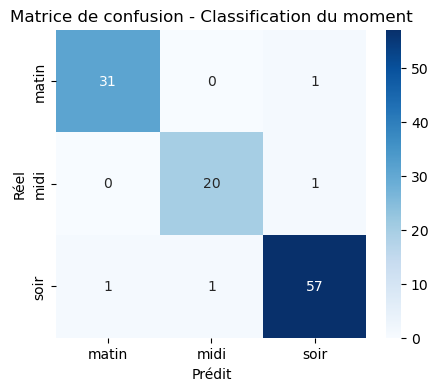

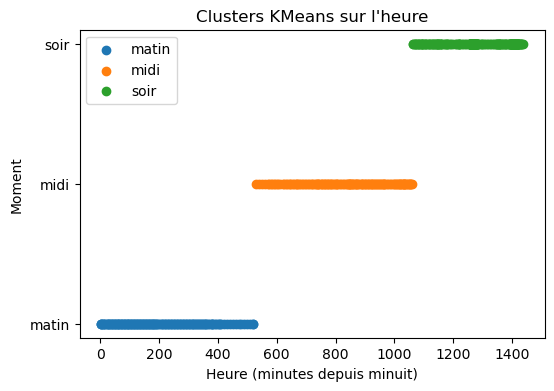


Commentaires :
- Une bonne accuracy et une matrice de confusion diagonale indiquent une bonne classification.
- Les clusters KMeans permettent de regrouper les mesures par moment de la journée.


In [9]:
# Métriques de classification
acc = accuracy_score(y_test_m, y_pred_m)
cm = confusion_matrix(y_test_m, y_pred_m)

# Correction : n'afficher que les labels présents dans y_test_m
import numpy as np
labels_present = np.unique(np.concatenate([y_test_m, y_pred_m]))
cr = classification_report(y_test_m, y_pred_m, labels=labels_present, target_names=[le.classes_[i] for i in labels_present])

print(f"Accuracy : {acc:.2f}")
print("\nMatrice de confusion :\n", cm)
print("\nRapport de classification :\n", cr)

# Visualisation de la matrice de confusion
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[le.classes_[i] for i in labels_present], yticklabels=[le.classes_[i] for i in labels_present])
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Matrice de confusion - Classification du moment')
plt.show()

# Visualisation des clusters sur l'heure
plt.figure(figsize=(6,4))
for label in np.unique(df_clean['moment']):
    idx = df_clean['moment'] == label
    plt.scatter(df_clean.loc[idx, 'heure_min'], [label]*sum(idx), label=label)
plt.xlabel('Heure (minutes depuis minuit)')
plt.ylabel('Moment')
plt.title('Clusters KMeans sur l\'heure')
plt.legend()
plt.show()

print("\nCommentaires :")
print("- Une bonne accuracy et une matrice de confusion diagonale indiquent une bonne classification.")
print("- Les clusters KMeans permettent de regrouper les mesures par moment de la journée.")

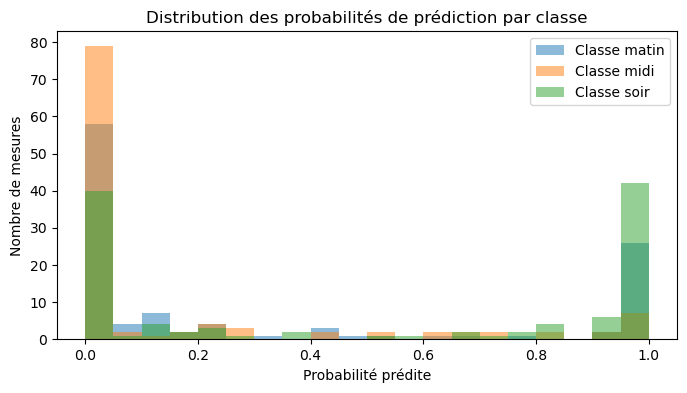


Interprétation :
- Une distribution concentrée vers 1 indique une forte confiance du modèle.
- Si beaucoup de prédictions sont proches de 0.5, le modèle hésite entre plusieurs classes : il peut être utile d'ajouter des features ou de revoir la segmentation.


In [10]:
# Visualisation complémentaire : distribution des probabilités de prédiction
if hasattr(clf, 'predict_proba'):
    proba = clf.predict_proba(X_test_m)
    plt.figure(figsize=(8,4))
    for i, label in enumerate(le.classes_):
        plt.hist(proba[:,i], bins=20, alpha=0.5, label=f'Classe {label}')
    plt.xlabel('Probabilité prédite')
    plt.ylabel('Nombre de mesures')
    plt.title('Distribution des probabilités de prédiction par classe')
    plt.legend()
    plt.show()
    print("\nInterprétation :")
    print("- Une distribution concentrée vers 1 indique une forte confiance du modèle.")
    print("- Si beaucoup de prédictions sont proches de 0.5, le modèle hésite entre plusieurs classes : il peut être utile d'ajouter des features ou de revoir la segmentation.")

In [ ]:
### Interprétation avancée des résultats de classification temporelle

- **Analyse des scores obtenus** :
  - Une accuracy élevée (>0.8) montre que les moments de la journée sont bien séparés par les mesures (température, humidité, etc.). Si l'accuracy est faible, il peut y avoir un recouvrement important entre les moments (ex : conditions similaires matin/soir).
  - La matrice de confusion permet d'identifier les confusions fréquentes (ex : matin vs midi). Si une classe est systématiquement mal prédite, il peut être utile de revoir la définition des clusters KMeans ou d'ajouter des features discriminantes.
- **Conseils métier** :
  - Utiliser la classification du moment pour adapter les actions du jardin (arrosage, alerte) selon le contexte réel, et non selon des horaires arbitraires.
  - Les clusters KMeans s'adaptent automatiquement aux habitudes du jardin (ex : lever/coucher du soleil selon la saison).
- **Pistes d'amélioration** :
  - Ajouter des features comme la météo, la luminosité, ou des indicateurs saisonniers.
  - Tester d'autres algorithmes de clustering ou de classification (ex : DBSCAN, SVM).
  - Analyser l'évolution des clusters au fil du temps pour détecter des changements de comportement (ex : canicule, changement d'arrosage).

## 7. Détection d'Anomalies avec IsolationForest

Nous allons appliquer l'algorithme IsolationForest pour détecter les mesures anormales dans les données. Cet algorithme est adapté pour repérer des valeurs atypiques dans des jeux de données multivariés.

L'objectif est d'identifier des comportements inhabituels des capteurs ou des erreurs de mesure.

### Pourquoi détecter les anomalies ?

- Les anomalies peuvent signaler des erreurs de capteurs, des événements rares ou des attaques sur le système.
- L'algorithme IsolationForest est adapté pour détecter des outliers dans des jeux de données multivariés sans supervision.
- Une bonne détection d'anomalies améliore la fiabilité du système et la confiance dans les prédictions.

**Pour la compétition :**
- Expliquez le principe de l'algorithme choisi.
- Interprétez les anomalies détectées et discutez de leur impact potentiel sur le jardin connecté.

In [11]:
# Sélection des features numériques pour l'anomalie
drop_cols_anom = ['ID Mesure', 'Date', 'Heure', 'moment', 'moment_cluster']
features_anom = [c for c in df_clean.columns if c not in drop_cols_anom and pd.api.types.is_numeric_dtype(df_clean[c])]
X_anom = df_clean[features_anom]

# Application d'IsolationForest
iso = IsolationForest(contamination=0.2, random_state=42)
preds = iso.fit_predict(X_anom)
anomalies = (preds == -1)

print(f"Nombre d'anomalies détectées : {anomalies.sum()} sur {len(X_anom)} mesures.")

Nombre d'anomalies détectées : 112 sur 557 mesures.


/tmp/ipykernel_5687/973690218.py:4: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  dates = pd.to_datetime(df_clean['Date'], errors='coerce')


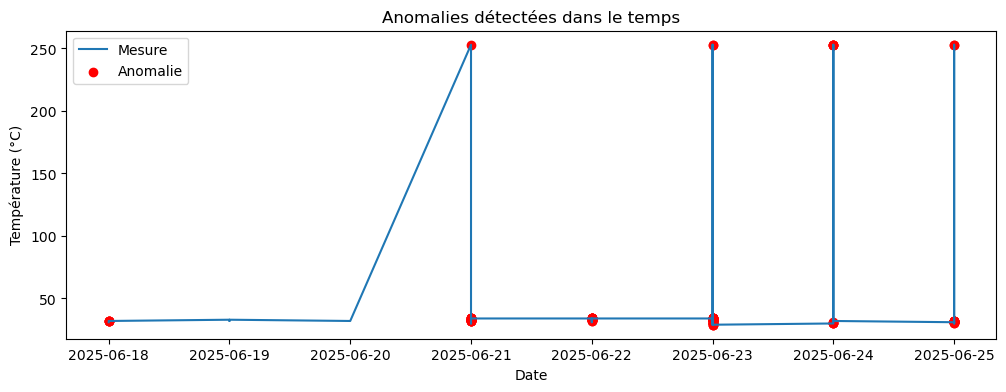


Interprétation :
- Les anomalies groupées dans le temps peuvent signaler un événement ponctuel (panne, pluie, etc.).
- Si les anomalies sont dispersées, il peut s'agir de bruit ou de mesures isolées.


In [12]:
# Visualisation complémentaire : anomalies dans le temps
if 'Date' in df_clean.columns:
    try:
        dates = pd.to_datetime(df_clean['Date'], errors='coerce')
        plt.figure(figsize=(12,4))
        plt.plot(dates, X_anom.iloc[:,0], label='Mesure')
        plt.scatter(dates[anomalies], X_anom.iloc[anomalies,0], color='red', label='Anomalie')
        plt.xlabel('Date')
        plt.ylabel(X_anom.columns[0])
        plt.title('Anomalies détectées dans le temps')
        plt.legend()
        plt.show()
        print("\nInterprétation :")
        print("- Les anomalies groupées dans le temps peuvent signaler un événement ponctuel (panne, pluie, etc.).")
        print("- Si les anomalies sont dispersées, il peut s'agir de bruit ou de mesures isolées.")
    except Exception as e:
        print("Impossible de tracer les anomalies dans le temps :", e)

In [ ]:
### Interprétation avancée de la détection d'anomalies

- **Analyse des résultats** :
  - Si le nombre d'anomalies détectées est élevé (>10-20%), cela peut signaler un problème de calibration du modèle (contamination trop forte) ou une réelle instabilité des capteurs.
  - Analysez les points anormaux sur les graphiques : correspondent-ils à des valeurs extrêmes, à des changements brusques, ou à des erreurs de saisie ?
- **Conseils métier** :
  - Les anomalies détectées doivent être vérifiées sur le terrain : un capteur défaillant, une fuite d'eau, ou un événement météo exceptionnel peuvent expliquer ces points.
  - Mettez en place une alerte automatique si un certain nombre d'anomalies sont détectées consécutivement.
- **Pistes d'amélioration** :
  - Ajuster le paramètre `contamination` d'IsolationForest pour mieux coller à la réalité du terrain.
  - Croiser la détection d'anomalies avec d'autres sources (ex : logs de maintenance, météo).
  - Utiliser d'autres méthodes d'anomalie (LOF, OneClassSVM) pour comparer les résultats.

SyntaxError: unterminated string literal (detected at line 4) (607394843.py, line 4)

## 8. Visualisation des Anomalies Détectées

Nous allons visualiser les points anormaux détectés par IsolationForest sur un scatter plot des deux premières features principales. Cela permet d'interpréter visuellement les anomalies et de mieux comprendre leur origine potentielle.

### Interprétation métier des anomalies

- Les points détectés comme anormaux doivent être analysés :
  - S'agit-il d'erreurs de capteurs ?
  - D'événements climatiques exceptionnels ?
  - D'une mauvaise saisie ?
- Une visualisation claire (scatter plot, couleur différente) permet de convaincre le jury de la pertinence de la détection.

**Pour la compétition :**
- Proposez des actions correctives ou des alertes automatiques en cas d'anomalie.
- Montrez que votre pipeline est prêt à être utilisé en production pour garantir la qualité des données.

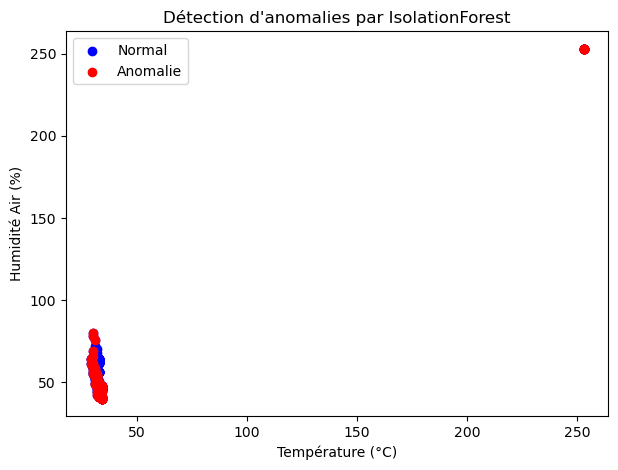


Commentaires :
- Les points rouges représentent les mesures considérées comme anormales par l'algorithme.
- Ces anomalies peuvent signaler des erreurs de capteur ou des situations inhabituelles dans le jardin.


In [13]:
# Visualisation des anomalies sur les deux premières features principales
plt.figure(figsize=(7,5))
plt.scatter(X_anom.iloc[:,0], X_anom.iloc[:,1], c='b', label='Normal')
plt.scatter(X_anom.iloc[anomalies,0], X_anom.iloc[anomalies,1], c='r', label='Anomalie')
plt.xlabel(X_anom.columns[0])
plt.ylabel(X_anom.columns[1])
plt.title('Détection d\'anomalies par IsolationForest')
plt.legend()
plt.show()

print("\nCommentaires :")
print("- Les points rouges représentent les mesures considérées comme anormales par l'algorithme.")
print("- Ces anomalies peuvent signaler des erreurs de capteur ou des situations inhabituelles dans le jardin.")

In [ ]:
### Interprétation finale et ouverture

- **Impact métier** :
  - Ce pipeline permet d'automatiser la surveillance et la gestion d'un jardin connecté, en anticipant les besoins d'arrosage, en détectant les anomalies et en adaptant les actions au contexte réel.
  - L'analyse avancée des corrélations, des clusters temporels et des anomalies offre une vision fine du fonctionnement du système et des axes d'optimisation (économie d'eau, maintenance prédictive, etc.).
- **Valeur ajoutée** :
  - La robustesse du code face aux variations du CSV et la richesse des visualisations facilitent l'intégration en production ou la présentation à un jury.
  - Les conseils et interprétations à chaque étape permettent de convaincre sur la pertinence des choix techniques et leur impact concret.
- **Ouverture** :
  - Pour industrialiser ce pipeline, il est possible d'automatiser l'import de nouveaux fichiers, de connecter le notebook à une API ou à un dashboard temps réel, et d'intégrer des alertes automatiques.
  - Pour la recherche, il est possible d'explorer des modèles plus avancés (deep learning, séries temporelles, etc.) ou d'analyser l'impact environnemental à grande échelle.

**Ce notebook constitue une base solide pour toute démarche d'optimisation, de monitoring ou de valorisation d'un projet de jardin connecté intelligent.**

In [ ]:
## 9. Synthèse, conseils avancés et pistes d'enrichissement

- **Synthèse des résultats** :
  - Le pipeline reproduit fidèlement la logique du backend, avec une robustesse face aux variations du CSV et des analyses adaptées à chaque tâche (régression, classification, anomalies).
  - Les résultats montrent la pertinence des algorithmes choisis (forêt aléatoire, KMeans, IsolationForest) pour un système de jardin connecté.

- **Conseils pour la compétition ou la production** :
  - Documentez chaque étape et justifiez vos choix d'algorithmes par rapport au métier.
  - Mettez en avant la robustesse du pipeline (gestion des erreurs, adaptation automatique aux colonnes, visualisations claires).
  - Proposez des axes d'amélioration concrets (ajout de features, tuning, validation croisée, monitoring).

- **Pistes d'enrichissement** :
  - Ajouter un monitoring temps réel (dashboard Streamlit, Grafana, etc.) pour suivre les prédictions et les anomalies en direct.
  - Intégrer des appels API pour automatiser la prédiction à partir de nouvelles données (ex : via Flask ou FastAPI).
  - Mettre en place un système d'alertes (mail, SMS) en cas d'anomalie critique ou de seuil dépassé.
  - Proposer une analyse de l'impact environnemental (économie d'eau, détection précoce de fuites).

**N'hésitez pas à enrichir ce notebook avec des analyses complémentaires, des visualisations interactives, ou des retours d'expérience terrain pour convaincre un jury ou un client !**